In [1]:
from parameters import Parameters
from transformers import DistilBertTokenizer, DistilBertForMaskedLM, BertForMaskedLM
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import random
from torch.utils.data import DataLoader, RandomSampler
import torch
import numpy as np, pandas as pd
import ast
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from IPython.display import clear_output
import nltk
import pytextrank
from tqdm import tqdm
import spacy
from model_generator import Fluency
from model_coverage import KeywordCoverage
from model_guardrails import *
import time
params = Parameters()
import matplotlib.pyplot as plt
import threading, queue
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from ast import literal_eval
df = pd.read_csv(params.dataset_filename, low_memory=False)

In [1]:
import re
regex = re.compile(r"[A-Za-z]\.[A-Za-z]")

In [3]:
if regex.search('this is a url http://www.abc.com and so is this abc.com and also this abc.co.uk but this is a missed period.yes'):
    print('fond')

fond


In [11]:
def collate_func(triplets):
    return list(zip(*triplets))
    # return [desc for desc,msg,loc in triplets], [msg for desc,msg,loc in triplets], [loc for desc,msg,loc in triplets]


In [2]:
summarizer = Fluency(load_pretrained='summarizer')

Loaded pretrained summarizer model, tokenizer


In [12]:
# df = pd.read_csv(params.dataset_filename, low_memory=False)
good_idxs = df.index[np.array([isinstance(x, str) for x in df.desc_clean_msg_stripped]) * np.array([isinstance(x,str) for x in df.msg_clean])]
batch_size = 4
descs = df.desc_clean_msg_stripped[good_idxs]
msgs = df.msg_clean[good_idxs]
locs = [literal_eval(x) for x in df.desc_clean_msg_stripped_locs[good_idxs]]

dataset = [(desc, msg, loc) for desc,msg,loc in zip(descs, msgs, locs)]
train_test_split = 0.8
N_train = int(len(dataset) * train_test_split)
N_val = len(dataset) - N_train
d_train, d_val = torch.utils.data.dataset.random_split(dataset, [N_train, N_val])
dl_train = DataLoader(dataset=d_train, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_func)
dl_val = DataLoader(dataset=d_val, batch_size=8, shuffle=True, drop_last=True, collate_fn=collate_func)

In [3]:
texts = ["""A prewar Rosario Candela architectural masterpiece, this sun-flooded corner 14 into 11 room grand duplex was expertly renovated by renowned architect Mary Burnham of MBB Architects in partnership with designer Rachel Laxer and home builder Josh Weiner of Silver Lining. The largest home in the building, Apartment 10/11A has five bedrooms, five full bathrooms and two powder rooms. The residence has undergone a complete state-of-the-art restoration and modernization with every room being completely gutted and put back together with no expense being spared and utilizing the best of materials and systems while restoring the elegance of historic details. Perfect for both entertaining and everyday living, there are ceilings up to 10' 8", two wood burning fireplaces, a balcony, raised doorways, perfectly restored original oak wood flooring as well as new rift quarter sawn white oak flooring, new windows, custom millwork, plaster moldings, bespoke E.R. Butler & Co. hardware, specialty paint finishes, and radiant heat in the kitchen, mud room and all bathrooms. All mechanical elements of this sophisticated home have been fully modernized including new electrical, new plumbing and a state-of-the-art Savant Pro Home Technology system which integrates the extensive audio/video components, Lutron lighting system, motorized shades and HVAC. The Savant system allows you to control the entire home through your cell phone or the multiple iPads in the residence. There is a five-zone HVAC system with temperature controlled zones for AC and each room having a control for heat. The home has Cat5e cabling, a Panasonic phone and intercom system, wired WAPs throughout for excellent WiFi connectivity, in-ceiling speakers throughout and it is wired for televisions in seven rooms. A semi-private elevator landing opens onto a regal 31-foot long entrance gallery that spans the beautiful enfilade of formal spaces which face south, east and west. Off the gallery is an exquisite powder room, an oversized coat closet, and a discreet china closet hidden under the staircase. The sun-drenched living room boasts three oversized windows which face south. This magnificent room is 28' 7" by 20' 2" and has the first wood burning fireplace. Adjacent is a palatial 26-foot long corner library with four windows facing south and east which has been meticulously restored and has the original distinguished wood paneling, original Tudor style plaster molded ceiling and frieze, and the second wood burning fireplace. Next is a corner formal dining room which has been transformed into an incredible entertainment room which has four windows facing south and west and has a built-in banquette for dining. The corner eat-in kitchen is open to this room and can be closed off by concealed pocket doors if you want to formally entertain. The kitchen has custom Bulthaup cabinetry, quartzite countertops by Walker Zanger, porcelain tile flooring by Fibra Collection, and a center island clad in a Luce Di Luna slab with seating. It is equipped with top-of-the-line appliances including a Subzero refrigerator and two freezer drawers, a Subzero wine refrigerator, two Subzero refrigerator drawers, two Gaggenau ovens, a Gaggenau five burner range with a vented hood, a Gaggenau warming drawer, two Miele dishwashers, a Franke sink and an endless amount of storage. Off of the kitchen is an incredible large windowed mudroom with built-in wood storage lockers and shelving as well as a second windowed powder room, a balcony and a back staircase leading to the 11th floor.""",
            """Spacious 3 bedroom, 2 bathroom home with beautiful East River views and oversized balcony with direct access from both living room and primary bedroom. Large kitchen with pass-through to living room. Living room with plenty of room for dining, piano and more!
Primary bedroom is almost 400 sq ft and could accommodate a king sized bed, sitting room and home office. Closets are abundant and one walk-in could easily convert to 3rd bathroom or laundry room.
Two additional bedrooms could also accommodate king sized beds, desks etc. 
W/D allowed. Cats & Dog friendly. 45 East End Ave permits up to 65% Financing.

45 East End Avenue was built in 1951 by acclaimed New York City architect firm Emery Roth & Sons. The building has full-time doorman, live-in resident manager, laundry room, roof deck, parking garage, storage & bike room.
Perched over the promenade, 45 East End shareholders enjoy easy access to the outdoors; the John Finley Walkway, the Carl Schurz dog run, the 90th St Ferry Terminal, allowing for an easy commute for Downtown workers and very close to the 83rd Street entrance to the Second Avenue Subway. 
The co-op boasts strong financials while also completing a number of capital projects.""",
        """This pre-owned 2022 Acura MDX has the Platinum White Pearl exterior with the Red interior. It is equipped with the Tech Package, the A-Spec package, navigation, blind spot monitors, lane keep assist, heated/cooled seats, a sunroof, and much more. It has been professionally inspected by a Sewell technician. Sewell has been serving Texans for over 110 years and we look forward to serving you. There is a reason Sewell customers come back again and again. It is because we treat everyone like a lifelong customer the moment they walk in the door. Simply put, we put the relationship before the sale. It is an attitude we have had since our founding here in Texas over a century ago. Let us earn your lifelong business today.""",
        """Beautiful 2 story home, in the best neighborhood. Very well maintained 4 bedroom with sitting area , 2 living room, 2.5 bathroom, relaxing covered patio leading to a heartwarming relaxing deck, facing towards the greenery. Imagine yourself living in a house that gives you peace and happiness of living in the woods, as you walk to the backyard, to visualize a beautiful scenic view. """,
        """It comes after new board member, Tesla boss Elon Musk, asked his followers in a Twitter poll whether they wanted the feature.

Many users have long called for an edit button but there are concerns about how to execute it.

Twitter said it would start testing the idea in the coming months.

The social media firm's communications team tweeted: "Now that everyone is asking… yes, we've been working on an edit feature since last year!"""]
texts.append('I am a godly')
bodies = texts

In [4]:
with torch.no_grad():
    z, _ = summarizer.decode_batch(texts, sample=True)
    y, _ = summarizer.decode_batch(texts)

In [5]:
z

['An prewar Rosario Candela architectural masterpiece, this sun-flooded corner 14 into 11 room grand duplex was expertly renovated by renowned architect Mary Burnham of MBB Architects in partnership with designer Rachel Laxer and home builder Josh Weiner of Silver Lining. The largest home in the building, Apartment 10/11A<|endoftext|>',
 'Spacious 3 bedroom, 2 bathroom home with beautiful East River views and oversized balcony with direct access from both living room and kitchen with passthrough to living room. Living room. Living room with plenty with plenty of room dining, piano and more! Primary bedroom is Primary bedroom is almost 400 sq ft and could accommodate a king sized bed, sitting room<|endoftext|>',
 'This preowned 2022 Acura MDX Platinum White Pearl exterior with the Red interior. It is equipped with the Tech Package, the A-spec package,, apartment, navigation, blind spot monitors, spot, lane lane keep keep assist,cooled seats, seats, a sunroof, much more. It has been prof

In [6]:
y

['An prewar Rosario Candela architectural masterpiece, this sun-flooded corner 14 into 11 room grand duplex was expertly renovated by renowned architect Mary Burnham of MBB Architects in partnership with designer Rachel Laxer and home builder Josh Weiner of Silver Lining. The largest home in the building, Apartment 10/11A<|endoftext|>',
 'Spacious 3 bedroom, 2 bathroom home with beautiful East River views and oversized balcony with direct access from both living room and primary kitchen with passthrough to living room. Living room. Living room with plenty of room for dining, piano and more! Primary bedroom is Primary bedroom is almost 400 sq ft and could accommodate a king sized bed, sitting room<|endoftext|>',
 'This preowned 2022 Acura MDX Platinum White Pearl exterior with the Red interior. It is equipped with the Tech Package, the A-spec package, package,,,,,,, blind spot monitors, lane keep assist, heated/cooled seats, a sunroof,roof, much more. It has been<|endoftext|> <|startoft

In [4]:
def preprocess_batch(descs, device='cuda', max_input_len=511-70, max_output_len=70):
    inputs = summarizer.tokenizer(descs, truncation=True, max_length=max_input_len)
    summ_inp = summarizer.tokenizer([summarizer.tokenizer.bos_token + desc for desc in descs], truncation=True, max_length=max_output_len)
    inputs['input_ids'] = [torch.LongTensor(input_id + summ_in) for input_id,summ_in in zip(inputs.input_ids, summ_inp.input_ids)]
    inputs['attention_mask'] = [torch.LongTensor(attn_input + attn_summ) for attn_input,attn_summ in zip(inputs.attention_mask, summ_inp.attention_mask)]
    inputs['input_ids'] = torch.nn.utils.rnn.pad_sequence(inputs.input_ids, batch_first=True, padding_value=summarizer.tokenizer.pad_token_id)
    inputs['attention_mask'] = torch.nn.utils.rnn.pad_sequence(inputs.attention_mask, batch_first=True, padding_value=0)

    outputs = inputs['input_ids']
    bos_token_idx = torch.where(outputs.eq(summarizer.tokenizer.bos_token_id))[1].tolist()
    first_pad_idx = [torch.where(inpid.eq(summarizer.tokenizer.pad_token_id))[0][0].item() if (summarizer.tokenizer.pad_token_id in inpid) else len(inpid) for inpid in outputs]
    targets = []
    for i,output in enumerate(outputs):
        targets.append(torch.cat((output[bos_token_idx[i]+1:first_pad_idx[i]], torch.IntTensor([summarizer.tokenizer.eos_token_id]))))
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=-1)

    return inputs.to(device), targets.to(device)

In [5]:
summarizer.device='cuda'
x,y = preprocess_batch(texts)
with torch.no_grad():
    out = summarizer.model(input_ids=x.input_ids, attention_mask=x.attention_mask)
    logits_shift = out.logits[:,-y.shape[1]:]
    loss = torch.nn.CrossEntropyLoss(ignore_index=-1)(logits_shift.contiguous().view(-1,len(summarizer.tokenizer)), y.contiguous().view(-1))

In [6]:
loss

tensor(0.8354, device='cuda:0')

In [7]:
with torch.no_grad():
    out = summarizer.model(input_ids=x.input_ids, attention_mask=x.attention_mask, labels=x.input_ids)
    logits_shift = out.logits[:,-y.shape[1]:]

In [4]:
# def decode_batch(bodies, input_past=None, sample=False, return_logprobs=False):
input_past = None
sample=False
return_logprobs = False

N = len(bodies)
current = summarizer.tokenizer([summarizer.tokenizer.bos_token] * N, return_tensors='pt').input_ids.to(summarizer.device)
build_up = None
total_logprobs = []

if input_past is None:
    inputs, _ = summarizer.preprocess_input(bodies)
    input_past = summarizer.model(**inputs)
past = input_past.past_key_values

while build_up is None or (build_up.shape[1] < summarizer.max_output_length and not all([summarizer.tokenizer.eos_token_id in build for build in build_up])):
    outputs = summarizer.model(current, past_key_values=past)
    logits = outputs.logits
    past = outputs.past_key_values
    probs = torch.nn.functional.softmax(logits, dim=2).squeeze(1)
    logprobs = torch.nn.functional.log_softmax(logits, dim=2)
    if sample:
        current = torch.multinomial(probs, 1)
    else:
        current = torch.argmax(logprobs, dim=2)

    if build_up is None:
        build_up = current
    else:
        build_up = torch.cat((build_up, current), dim=1)

    if return_logprobs:
        selected_logprobs = logprobs[torch.arange(N), 0, current.squeeze()].unsqueeze(1)
        total_logprobs.append(selected_logprobs)

build_up = [build.tolist() for build in build_up]
end_idxs = [summarizer.max_output_length+1 if summarizer.tokenizer.eos_token_id not in build else build.index(summarizer.tokenizer.eos_token_id) for build in build_up]
outputs = [summarizer.tokenizer.decode(build) for build in build_up]
    # if return_logprobs:
    #     return outputs, torch.cat(total_logprobs, dim=1), input_past, end_idxs
    # else:
    #     return outputs, end_idxs

In [5]:
outputs

['ed<|endoftext|> <|pad|> <|endoftext|> <|pad|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 " views views and views and views are you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you're you",
 ' a <|pad|> <|endoftext|> <|pad|> <|endoftext|>\n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \n <|startoftext|> \

In [38]:
probs.shape

torch.Size([3, 50259])

In [23]:
z = summarizer.decode_batch(texts, return_logprobs=False, sample=True)
y = summarizer.decode_batch(texts, sample=False)

In [12]:
z = summarizer.model(**summarizer.tokenizer(texts, return_tensors='pt', truncation=True, max_length=511-70, padding=True).to('cuda'))

In [22]:
summarizer.tokenizer.decode(torch.argmax(z.logits, dim=2)[0])

"<|pad|> <|pad|> <|pad|>  Ros <|pad|>  Candela architecture masterpiece,, sun-floodood corner corner into 11 room grand grandlexlex expert expert renovated renovated by architect Mary Mary Burnham,bB in <|pad|> <|pad|> <|pad|> <|pad|>  Lax <|pad|> <|pad|> <|pad|> <|pad|>  Josh Weiner of <|pad|>  L L.. largest home in the building and Apartment 10//ario has has bedrooms<|endoftext|> bedrooms<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> <|pad|> <|endoftext|>,<|endoftext|><|endoftext|><|endoftext|> you into,. a matter, or or without, only of the <|pad|>  the, you or,, the,, and,,. and,. and and and and and and and, and, and or,,,, and,, and,,, and,,,,,,, a,,,,,,,,,,, and,, and,,, and,,, and,,,,,.., & &. and,,, and,,,,,, and,,,

In [24]:
z

(['<|endoftext|>', '<|endoftext|>', '<|endoftext|>'], [0, 0, 0])

In [2]:
batch_size=4
descs = []
locs = []
for i,(desc,loc) in enumerate(zip(df.desc_clean, df.desc_clean_msg_stripped_locs)):
    if isinstance(desc,str) and isinstance(loc,str) and isinstance(ast.literal_eval(loc), list):
        descs.append(desc)
        locs.append(ast.literal_eval(loc))

def collate_func(batch):
    descs, locs = [item[0] for item in batch], [item[1] for item in batch]
    return descs, locs

dataset = list(zip(descs, locs))
N = len(dataset)
N_train = int(N * 0.8)
N_val = N - N_train
d_train, d_val = torch.utils.data.dataset.random_split(dataset, [N_train, N_val])
dl_train = DataLoader(dataset=d_train, batch_size=batch_size, drop_last=True, shuffle=True, collate_fn=collate_func)
dl_val = DataLoader(dataset=d_val, batch_size=batch_size, drop_last=True, shuffle=True, collate_fn=collate_func)

In [3]:
my_queue = queue.Queue()
def background_tokenizer(descs, msgs, locs, q):
    q.put(scorers['coverage']['model'].build_inputs(descs, msgs, locs))

In [3]:
descs = []
msgs = []
locs = []
for i,(desc,msg,loc) in enumerate(zip(df.desc_clean, df.msg_clean, df.desc_clean_msg_stripped_locs)):
    if isinstance(desc,str) and isinstance(msg,str) and isinstance(loc,str) and isinstance(ast.literal_eval(loc), list):
        descs.append(desc)
        msgs.append(msg)
        locs.append(ast.literal_eval(loc))

In [4]:
kw_cov = KeywordCoverage(_type='coverage')

Loaded fine-tuned coverage model, tokenizer


 25%|██▍       | 522/2099 [29:14<1:28:19,  3.36s/it]


KeyboardInterrupt: 

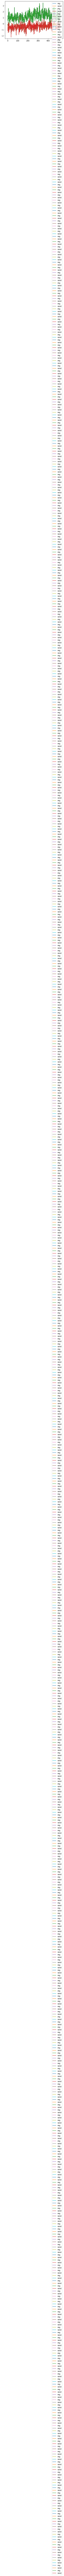

In [8]:
batch_size = 20
rand_msgs_idx = list(range(len(msgs)))
np.random.shuffle(rand_msgs_idx)
rand_msgs = [msgs[i] for i in rand_msgs_idx]
scores = []
rand_scores = []
n_items = 0
for i in tqdm(range(0,len(descs),batch_size)):
    n_items += batch_size
    batch_d = descs[i:i+batch_size]
    batch_m = msgs[i:i+batch_size]
    batch_l = locs[i:i+batch_size]
    batch_r_msgs = rand_msgs[i:i+batch_size]
    score, _ = kw_cov.score_non_threaded(batch_m, batch_d, batch_l)
    score_rand, _ = kw_cov.score_non_threaded(batch_r_msgs, batch_d, batch_l)
    scores.append(score.sum().item())
    rand_scores.append(score_rand.sum().item())
    if n_items > 500:
        plt.plot(scores, label='reg')
        plt.plot(rand_scores,label='rand')
        plt.legend()
        break

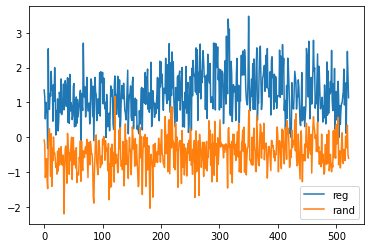

In [9]:
plt.plot(scores, label='reg')
plt.plot(rand_scores,label='rand')
plt.legend()

In [4]:
scorers = {}
scorers['coverage'] = {'importance':10.0, 'model':KeywordCoverage(_type='coverage')}
scorers['fluency'] = {'importance':10.0, 'model':Fluency(load_pretrained='fluency')}
scorers['patpen'] = {'importance':5.0, 'model':PatternPenalty()}
scorers['lengthpen'] = {'importance':2.0, 'model':LengthPenalty(params.max_output_length)}
scorers['reppen'] = {'importance':2.0, 'model':RepeatPenalty()}


Loaded fine-tuned coverage model, tokenizer
Loaded fine-tuned fluency model, tokenizer


In [8]:
for batch in dl_val:
    descs, locs = batch
    my_thread = threading.Thread(target=background_tokenizer, args=(descs, [""] * len(descs), locs, my_queue))
    my_thread.start()
    my_thread.join()
    withouts = my_queue.get()
    break

In [10]:
type(withouts)

tuple

In [18]:
# df = pd.read_csv(params.dataset_filename, low_memory=False)
# descs = []
# locs = []
# for i,(desc,loc) in enumerate(zip(df.desc_clean, df.desc_clean_msg_stripped_locs)):
#     if isinstance(desc,str) and isinstance(loc,str) and isinstance(ast.literal_eval(loc), list):
#         descs.append(desc)
#         locs.append(ast.literal_eval(loc))

# def collate_func(batch):
#     descs, locs = [item[0] for item in batch], [item[1] for item in batch]
#     return descs, locs
batch_size=4
dataset = list(zip(descs, locs))
N = len(dataset)
N_train = int(N * 0.8)
N_val = N - N_train
d_train, d_val = torch.utils.data.dataset.random_split(dataset, [N_train, N_val])
dl_train = DataLoader(dataset=d_train, batch_size=batch_size, drop_last=True, shuffle=True, collate_fn=collate_func)
dl_val = DataLoader(dataset=d_val, batch_size=batch_size, drop_last=True, shuffle=True, collate_fn=collate_func)

In [16]:
class Dataset:
    def __init__(self, data):
        self.descs = [item[0] for item in data]
        self.locs = [item[1] for item in data]
    def __getitem__(self, i):
        return self.descs[i], self.locs[i]
    def __len__(self):
        return len(self.descs)

In [19]:
for batch in dl_val:
    break

In [20]:
batch

(['Here?s a home with impeccable presentation on a family friendly 865m2 block ? it?s the home, block, and location you?ve been looking for! Move in ready thanks to the improvements and quality of care the current owners have given the property, it delivers beautifully proportioned living spaces and a zoned layout to suit families of all ages.  Its modern style showcases gleaming floating floors, luxury-soft carpets, crisp white cabinetry, and sparkling stone benches within a neutral and bright setting. Featuring stainless steel appliances, a dishwasher and excellent storage in the kitchen, ducted heating, reverse cycle air conditioning, and evaporative cooling, everything has been considered for comfort and convenience. Three bedrooms all have built in robes (master with ensuite), the family bathroom is bright and has a separate toilet, while the laundry at the rear is a great size for additional storage. For the daily flow between spaces and an ideal entertaining area, the covered de

In [5]:
summarizer = Fluency(load_pretrained='summarizer')
summarizer.model = summarizer.model.to(summarizer.device)


Loaded pretrained summarizer model, tokenizer


In [6]:
df = pd.read_csv(params.dataset_filename, low_memory=False)
descs = []
locs = []
batch_size = 4
for i,(desc,loc) in enumerate(zip(df.desc_clean, df.desc_clean_msg_stripped_locs)):
    if isinstance(desc,str) and isinstance(loc,str) and isinstance(ast.literal_eval(loc), list):
        descs.append(desc)
        locs.append(ast.literal_eval(loc))

def collate_func(batch):
    descs, locs = [item[0] for item in batch], [item[1] for item in batch]
    return descs, locs

dataset = list(zip(descs, locs))
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True, shuffle=True, collate_fn=collate_func)

model = summarizer.model.train()

In [7]:
i = 0
batches = []
for batch in dataloader:
    batches.append(batch)
    i += 1
    if i > 100:
        break

In [8]:
def decode_batch(bodies, input_past=None, sample=False, return_logprobs=False):
    N = len(bodies)
    current = summarizer.tokenizer([summarizer.tokenizer.bos_token] * N, return_tensors='pt').input_ids.to(summarizer.device)
    build_up = None
    total_logprobs = []

    t0 = time.time()
    if input_past is None:
        inputs, _ = summarizer.preprocess_input(bodies)
        input_past = summarizer.model(**inputs)
    past = input_past.past_key_values
    preprocess = time.time() - t0
    
    t0 = time.time()
    while build_up is None or (build_up.shape[1] < summarizer.max_output_length and not all([summarizer.tokenizer.eos_token_id in build for build in build_up])):
        outputs = summarizer.model(current, past_key_values=past)
        logits = outputs.logits
        past = outputs.past_key_values
        probs = torch.nn.functional.softmax(logits, dim=2).squeeze(1)
        logprobs = torch.nn.functional.log_softmax(logits, dim=2)
        if sample:
            current = torch.multinomial(probs, 1)
        else:
            current = torch.argmax(logprobs, dim=2)

        if build_up is None:
            build_up = current
        else:
            build_up = torch.cat((build_up, current), dim=1)

        if return_logprobs:
            selected_logprobs = logprobs[torch.arange(N), 0, current.squeeze()].unsqueeze(1)
            total_logprobs.append(selected_logprobs)
    main_loop = time.time() - t0
    
    t0 = time.time()
    build_up = [build.tolist() for build in build_up]
    end_idxs = [summarizer.max_output_length+1 if summarizer.tokenizer.eos_token_id not in build else build.index(summarizer.tokenizer.eos_token_id) for build in build_up]
    outputs = [summarizer.tokenizer.decode(build) for build in build_up]
    if return_logprobs:
        return outputs, torch.cat(total_logprobs, dim=1), input_past, end_idxs, preprocess, main_loop, time.time()-t0
    else:
        return outputs, end_idxs, preprocess, main_loop, time.time()-t0

In [9]:
times = {}
times['decode_first'] = {}
times['decode_second'] = {}
for key in ['tot','preprocess','main_loop','other']:
    times['decode_first'][key] = []
    times['decode_second'][key] = []
for batch in tqdm(batches):
    descs, locs = batch
    t0 = time.time()
    sampled_summaries, sampled_logprobs, input_past, sampled_end_idxs, preprocess, main_loop, other = decode_batch(descs, return_logprobs=True, sample=True)
    times['decode_first']['tot'].append(time.time()-t0)
    times['decode_first']['preprocess'].append(preprocess)
    times['decode_first']['main_loop'].append(main_loop)
    times['decode_first']['other'].append(other)
    with torch.no_grad():
        t0 = time.time()
        argmax_summaries, argmax_end_idxs, preprocess, main_loop, other = decode_batch(descs, input_past=input_past)
        times['decode_second']['tot'].append(time.time() - t0)
        times['decode_second']['preprocess'].append(preprocess)
        times['decode_second']['main_loop'].append(main_loop)
        times['decode_second']['other'].append(other)
    torch.cuda.empty_cache()

100%|██████████| 101/101 [01:59<00:00,  1.18s/it]


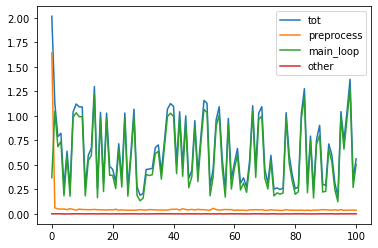

In [14]:
for key in times['decode_first'].keys():
    plt.plot(times['decode_first'][key],label=key)
plt.legend()

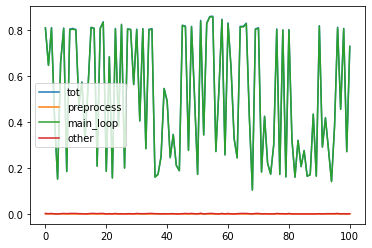

In [15]:
for key in times['decode_second'].keys():
    plt.plot(times['decode_second'][key],label=key)
plt.legend()

In [2]:
kw_cov = KeywordCoverage(_type='coverage')
hotwords = [x[1]['word'] for x in kw_cov.kw_ex.hotwords.items()]

Loaded fine-tuned coverage model, tokenizer


In [3]:
def collate_func(triplets):
    return [desc for desc,msg,loc in triplets], [msg for desc,msg,loc in triplets], [loc for desc,msg,loc in triplets]

In [4]:
good_idxs = df.index[np.array([isinstance(x, str) for x in df.desc_clean_msg_stripped]) * np.array([isinstance(x,str) for x in df.msg_clean])]
descs = df.desc_clean_msg_stripped[good_idxs]
msgs = df.msg_clean[good_idxs]
locs = [literal_eval(x) for x in df.desc_clean_msg_stripped_locs[good_idxs]]

dataset = [(desc, msg, loc) for desc,msg,loc in zip(descs, msgs, locs)]
train_test_split = 0.8
batch_size = 4
N_train = int(len(dataset) * train_test_split)
N_val = len(dataset) - N_train
d_train, d_val = torch.utils.data.dataset.random_split(dataset, [N_train, N_val])
dl_train = DataLoader(dataset=d_train, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_func)
dl_val = DataLoader(dataset=d_val, batch_size=8, shuffle=True, drop_last=True, collate_fn=collate_func)

In [5]:
def score(summaries, contents, locs, accs_without=None):
    with torch.no_grad():
        t0 = time.time()
        input_ids, is_masked, labels, attn_mask = kw_cov.build_inputs(contents, summaries, locs)
        first_build = time.time() - t0
        
        outputs = kw_cov.bert(input_ids=input_ids, attention_mask=attn_mask)
        preds = torch.argmax(outputs.logits, dim=2)
        n_masks = torch.sum(is_masked, dim=1).float()
        problem = False
        for idx in (n_masks==0).nonzero():
            print(contents[idx])
            problem = True
        if problem:
            sys.exit('================\nFOUND CONTENTS WITH NO MASKS\n============')
        accs_with = torch.sum(preds.eq(labels).long() * is_masked, dim=1).float() / n_masks
        accs_with = torch.nan_to_num(accs_with, nan=0)
        second_build = 0
        if accs_without is None:
            t0 = time.time()
            input_ids, is_masked, labels, attn_mask = kw_cov.build_inputs(contents, [""] * len(input_ids), locs)
            second_build = time.time() - t0
            outputs = kw_cov.bert(input_ids=input_ids, attention_mask=attn_mask)
            preds = torch.argmax(outputs.logits, dim=2)
            n_masks = torch.sum(is_masked, dim=1).float()
            accs_without = torch.sum(preds.eq(labels).long() * is_masked, dim=1).float() / n_masks
            accs_without = torch.nan_to_num(accs_without, nan=0)
        return accs_with - accs_without, accs_without, first_build, second_build

In [6]:
i = 0
batches = []
for batch in dl_val:
    batches.append(batch)
    i += 1
    if i > 100:
        break

In [7]:
times = []
i = 0
for batch in tqdm(batches):
    descs, msgs, locs = batch
    x,y,first,second = score(msgs, descs, locs)
    times.append([first, second])
    i+= 1
    if i > 30:
        break

 30%|██▉       | 30/101 [00:16<00:39,  1.79it/s]


In [9]:
print(np.mean([x[0] for x in times]))
print(np.mean([x[1] for x in times if x!=0]))

0.16907003618055774
0.1674566884194651


In [29]:
maskeds = []
for i in range(len(descs)):
    z = kw_cov.kw_ex.mask_doc(descs[i], kw_cov.tokenizer.encode(descs[i], truncation=True, max_length=511), locs[i])
    maskeds.append(torch.LongTensor(z))
    if not 103 in z:
        print(i)

In [6]:
inpid, is_mask, lbl, attn = kw_cov.build_inputs(descs, msgs, locs)

In [7]:
inpid.eq(kw_cov.tokenizer.mask_token_id).sum()

tensor(0, device='cuda:0')

In [9]:
unmaskeds = [torch.LongTensor(x) for x in kw_cov.tokenizer(descs, truncation=True, max_length=kw_cov.max_input_length).input_ids]

In [14]:

input_ids, labels = [], []
unmaskeds = [torch.LongTensor(x) for x in kw_cov.tokenizer(descs, truncation=True, max_length=kw_cov.max_input_length).input_ids]
summ_toks = [torch.LongTensor(x) for x in kw_cov.tokenizer(msgs, truncation=True, max_length=kw_cov.max_output_length).input_ids]
for summ_tok, loc, unmasked in zip(summ_toks, locs, unmaskeds):
    masked = torch.LongTensor(kw_cov.kw_ex.mask_doc(unmasked, loc, kw_cov.masking_scheme, kw_cov.n_hot_masks, kw_cov.n_loc_masks))
    input_ids.append(torch.cat((summ_tok, masked[1:])))
    labels.append(torch.cat((summ_tok, unmasked[1:])))

In [29]:
hot_masks, loc_masks = kw_cov.kw_ex.find_potential_masks(unmaskeds[0], locs[0])
hot_masks

[]

In [39]:
for tok in unmaskeds[0]:
    if tok.item() in kw_cov.kw_ex.hotwords.keys():
        print(tok)

tensor(6076)
tensor(2086)
tensor(5509)
tensor(2311)
tensor(18390)
tensor(4606)
tensor(3332)
tensor(5010)
tensor(28942)
tensor(2152)
tensor(5894)
tensor(5509)
tensor(2311)
tensor(8360)
tensor(9621)
tensor(2204)
tensor(2946)
tensor(16683)
tensor(7621)
tensor(5527)
tensor(2282)
tensor(10808)
tensor(11520)
tensor(2291)
tensor(23165)
tensor(2723)
tensor(2542)
tensor(7759)
tensor(2282)
tensor(3829)
tensor(13788)
tensor(16247)
tensor(3313)
tensor(2217)
tensor(2217)
tensor(7381)
tensor(5581)
tensor(2434)
tensor(3954)
tensor(2921)
tensor(3200)
tensor(2204)
tensor(4338)


In [38]:
102 in kw_cov.kw_ex.hotwords.keys()

False

In [132]:
msg_crit = np.asarray([isinstance(x, str) for x in df.msg_clean])
clicks_crit = np.asarray([isinstance(x, float) and x>0 for x in df.clicks])
good_idxs = df.index[msg_crit * clicks_crit]

dataset = list(zip(df.msg_clean[good_idxs], df.clicks[good_idxs]))
dataloader = DataLoader(dataset=dataset, drop_last=True, batch_size=20)
hotwords = Counter()
bad_tokens = [kw_cov.tokenizer.pad_token_id, kw_cov.tokenizer.cls_token_id, kw_cov.tokenizer.sep_token_id, kw_cov.tokenizer.unk_token_id, kw_cov.tokenizer.mask_token_id]
for word in ['one','two','three','four','five','six','seven','eight','nine','ten']:
    bad_tokens.append(kw_cov.tokenizer.encode(word)[1])
for batch in tqdm(dataloader):
    msgs, clicks = batch
    tokenized_msgs = kw_cov.tokenizer(list(msgs)).input_ids
    for tokenized_msg, msg, clicks in zip(tokenized_msgs, msgs, clicks):
        tokens = list(set(tokenized_msg))
        # nltk_words = word_tokenize(msg)
        # pos_tuples = nltk.pos_tag(nltk_words)
        # pos_tuples = [(x[0].lower(), x[1]) for x in pos_tuples]
        good_tokens = []
        for token in tokens:
            decoded = kw_cov.tokenizer.decode(token)
            if len(decoded) <=3 or '#' in decoded or \
                '[' in decoded or token in bad_tokens or \
                decoded in stop_words:
                continue
            good_tokens.append(token)
        hotwords.update({token:clicks.item() for token in good_tokens})


100%|██████████| 5120/5120 [00:27<00:00, 187.63it/s]


In [153]:
tmp = {item:val for item,val in hotwords.most_common()}
tot = sum(tmp.values())
new_hotwords = {}
runsum = 1.0
for token,val in tmp.items():
    runsum -= val / tot
    new_hotwords[token] = {'word':kw_cov.tokenizer.decode(token), 'val':runsum}

In [154]:
with open('hotwords.csv','w+') as f:
    for key,dic in new_hotwords.items():
        f.write(str(key)+','+dic['word']+','+str(dic['val'])+'\n')

In [149]:
key

2188

In [6]:
batches = []
i = 0
for batch in dl_val:
    batches.append(batch)
    i += 1
    if i > 30:
        break

In [7]:
times = []
i = 0
for batch in batches:
    descs, msgs, locs = batch
    t0 = time.time()
    x,y,z,q = build_inputs(descs, msgs, locs, batched=True)
    batch_time = time.time() - t0
    t0 = time.time()
    x,y,z,q = build_inputs(descs, msgs, locs, batched=False)
    unbatch_time = time.time() - t0
    times.append([batch_time, unbatch_time])
    print(i,end=',')
    i += 1
    if i > 30:
        break

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,

In [10]:
print(np.mean([time[0] for time in times]), np.mean([time[1] for time in times]))

0.8540611805454377 0.8541259073442028


In [89]:
np.mean(times)

0.7832068089515932

In [31]:
print('sample', np.mean([x[0] for x in times]))
print('argmax', np.mean([x[1] for x in times]))
print('sample_build_first', np.mean([x[2] for x in times]))
print('sample_build_second', np.mean([x[3] for x in times]))
print('argmax_build_first', np.mean([x[4] for x in times]))

sample 1.7701039929543771
argmax 0.9483082986647083
sample_build_first 0.8182468798852736
sample_build_second 0.8025983456642397
argmax_build_first 0.8087287872068344


In [24]:
np.mean([x[1] for x in times])

1.0519442250651698

In [13]:
for batch in dl_train:
    break

In [45]:
contents, summaries, locs = batch
# input_ids, is_masked, labels, attn_mask = kw_cov.build_inputs(contents, summaries, locs)

In [46]:
locations = locs
N = len(contents)
input_ids, labels = [], []
for content, summary, locs in zip(contents, summaries, locations):
    unmasked = torch.LongTensor(
        kw_cov.tokenizer.encode(content, truncation=True, max_length=511-70)
    )
    masked = torch.LongTensor(
        kw_cov.kw_ex.mask_doc(content, unmasked, locs,
            'prioritize_clicks', 10, 2)
    )
    summ_tok = torch.LongTensor(
        kw_cov.tokenizer.encode(summary, truncation=True, max_length=70)
    )
    # while len(summ_tok) + len(masked) >= self.tokenizer.model_max_length:
    #     if len(summ_tok) > self.max_output_length:
    #         summ_tok = summ_tok[:self.max_output_length-1]
    #     masked = masked[:self.tokenizer.model_max_length-len(summ_tok)-2]
    #     unmasked = unmasked[:self.tokenizer.model_max_length-len(summ_tok)-2]

    # input_ids.append(torch.cat((summ_tok, torch.LongTensor([kw_cov.tokenizer.sep_token_id]), masked)))
    # labels.append(torch.cat((summ_tok, torch.LongTensor([kw_cov.tokenizer.sep_token_id]), unmasked)))
    input_ids.append(torch.cat((summ_tok, masked[1:])))
    labels.append(torch.cat((summ_tok, unmasked[1:])))

input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=kw_cov.tokenizer.pad_token_id)
labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=kw_cov.tokenizer.pad_token_id)
is_masked = input_ids.eq(torch.LongTensor([kw_cov.tokenizer.mask_token_id]))
labels = (labels*is_masked) + (~is_masked * torch.LongTensor([-1]))
attn_mask = 1 * ~torch.eq(input_ids, kw_cov.tokenizer.pad_token_id)

In [39]:
kw_cov.tokenizer.decode(input_ids[0])

"[CLS] leave the hustle and bustle of the busy city life for your own brand new home approximately only 25 minutes from dunedin. this high quality newly built 3 bedroom home ( with ensuite ) is light, bright and spacious and tastefully designed with a fresh modern look. [SEP] [MASK] [MASK] kitchen - living - dining [MASK] lead to a [MASK] [MASK] where you can [MASK] [MASK] [MASK], just [MASK] for [MASK] your friends. a [MASK] [MASK] is a bonus as is the [MASK] nook. [MASK] [MASK] [MASK] with automatic [MASK] and [MASK] [MASK] as [MASK] as [MASK] of [MASK] [MASK]. obviously [MASK] glazed and insulated, as [MASK] as having a heat pump and log burner - and did i mention all the [MASK]? there's oodles! don't let this one get [MASK]! priced to sell! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [3]:
params = Parameters()
train_test_split = 0.8
df = pd.read_csv(params.dataset_filename, low_memory=False)
msgs = [msg for msg in df.msg_clean.tolist() if isinstance(msg, str)]

N = len(msgs)
N_train = int(N * train_test_split)
N_val = N - N_train
d_train, d_val = torch.utils.data.dataset.random_split(msgs, [N_train, N_val])

# dl_train = DataLoader(dataset=d_train, batch_size=batch_size, sampler=RandomSampler(d_train))
# dl_val = DataLoader(dataset=d_val, batch_size=batch_size, sampler=RandomSampler(d_val))

In [6]:
fluency = Fluency()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded default fluency model, tokenizer


In [ ]:
def preprocess_input(self, batch_msgs):
    inputs = self.tokenizer([self.tokenizer.bos_token + msg for msg in batch_msgs], return_tensors='pt', padding=True, truncation=True, max_length=self.max_output_length).to(self.device)
    outputs = self.tokenizer([msg + self.tokenizer.eos_token for msg in batch_msgs], return_tensors='pt', padding=True, truncation=True, max_length=self.max_output_length).to(self.device)
    for i,inpid in enumerate(outputs.input_ids):
        for j,item in enumerate(outputs['input_ids'][i]):
            if item == self.tokenizer.pad_token_id:
                outputs['input_ids'][i][j] = -1 
        if self.tokenizer.eos_token_id in inpid:
            continue
        outputs['input_ids'][i][-1] = self.tokenizer.eos_token_id
    return inputs, outputs

In [17]:
device='cuda'
class Dataset:
    def __init__(self, msgs):
        inputs, outputs = fluency.preprocess_input(msgs)
        self.input_ids = inputs.input_ids
        self.attn_mask = inputs.attention_mask
        self.outputs = outputs.input_ids
        
    def __getitem__(self, i):
        return self.input_ids[i].to(device), self.attn_mask[i].to(device), self.outputs[i].to(device)
    
    def __len__(self):
        return len(self.outputs)

In [18]:
dataset_val = Dataset(list(d_val)[:100])

In [19]:
dl_val = DataLoader(dataset=dataset_val, batch_size=4, shuffle=True, drop_last=True)

In [20]:
for batch in dl_val:
    break

In [22]:
x=fluency.model(input_ids=batch[0], attention_mask=batch[1])

In [23]:
x

CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[-3.6860e+01, -3.6337e+01, -4.0279e+01,  ..., -3.6974e+01,
           1.2288e+00, -4.8887e-01],
         [-7.8790e+01, -7.8542e+01, -8.1345e+01,  ..., -7.9637e+01,
           1.1315e+00, -5.1452e-01],
         [-9.6237e+01, -9.4862e+01, -1.0079e+02,  ..., -9.7972e+01,
           1.8087e+00, -2.2453e-02],
         ...,
         [-1.0023e+02, -9.8076e+01, -1.0043e+02,  ..., -9.8765e+01,
           1.5335e+00, -8.5993e-01],
         [-1.0046e+02, -9.8279e+01, -1.0068e+02,  ..., -9.9048e+01,
           1.5480e+00, -8.4824e-01],
         [-1.0035e+02, -9.8143e+01, -1.0052e+02,  ..., -9.8945e+01,
           1.5372e+00, -8.4978e-01]],

        [[-3.6860e+01, -3.6337e+01, -4.0279e+01,  ..., -3.6974e+01,
           1.2288e+00, -4.8887e-01],
         [-6.5507e+01, -6.9685e+01, -7.5213e+01,  ..., -6.8450e+01,
           1.1426e+00, -4.9745e-01],
         [-1.0925e+02, -1.0831e+02, -1.1557e+02,  ..., -1.1048e+02,
           2.4464e+00, -

In [265]:
end_loc

3072

In [377]:
bos_token, eos_token, pad_token ='<|startoftext|>', '<|endoftext|>', '<|pad|>'
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token=bos_token, eos_token=eos_token, pad_token=pad_token) #gpt2-medium
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Embedding(50259, 768)

In [369]:
def preprocess_batch(descs, device='cpu', max_input_len=511-70, max_output_len=70):
    inputs = tokenizer(descs, truncation=True, max_length=max_input_len)
    summ_inp = tokenizer([tokenizer.bos_token + desc for desc in descs], truncation=True, max_length=max_output_len)
    inputs['input_ids'] = [torch.LongTensor(input_id + summ_in) for input_id,summ_in in zip(inputs.input_ids, summ_inp.input_ids)]
    inputs['attention_mask'] = [torch.LongTensor(attn_input + attn_summ) for attn_input,attn_summ in zip(inputs.attention_mask, summ_inp.attention_mask)]
    inputs['input_ids'] = torch.nn.utils.rnn.pad_sequence(inputs.input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    inputs['attention_mask'] = torch.nn.utils.rnn.pad_sequence(inputs.attention_mask, batch_first=True, padding_value=0)

    outputs = inputs['input_ids']
    bos_token_idx = torch.where(outputs.eq(tokenizer.bos_token_id))[1].tolist()
    first_pad_idx = [torch.where(inpid.eq(tokenizer.pad_token_id))[0][0].item() if (tokenizer.pad_token_id in inpid) else len(inpid) for inpid in outputs]
    targets = []
    for i,output in enumerate(outputs):
        targets.append(torch.cat((output[bos_token_idx[i]+1:first_pad_idx[i]], torch.IntTensor([tokenizer.eos_token_id]))))
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=-1)
    
    return inputs.to(device), targets.to(device)

In [333]:
params = Parameters()
df = pd.read_csv(params.dataset_filename, low_memory=False)
train_test_split = 0.8
descs = [' '.join(x.split(' ')[:600]) for x in df.desc_clean if isinstance(x, str)]

N = len(descs)
N_train = int(N * train_test_split)
N_val = N - N_train
d_train, d_val = torch.utils.data.dataset.random_split(descs, [N_train, N_val])

In [361]:
z = DataLoader(dataset=list(range(10)), batch_size=2, shuffle=True)
for batch in z:
    print(batch,end=',')
print('')
for batch in z:
    print(batch,end=',')

tensor([4, 6]),tensor([5, 9]),tensor([1, 2]),tensor([8, 7]),tensor([0, 3]),
tensor([4, 3]),tensor([8, 7]),tensor([9, 1]),tensor([2, 6]),tensor([5, 0]),

In [409]:
d_val

In [370]:
x,y = preprocess_batch([descs[i] for i in range(10)], device='cpu')

In [371]:
x.input_ids.shape

torch.Size([10, 415])

In [380]:
out = model(input_ids=x.input_ids, attention_mask=x.attention_mask)#, attention_mask=x.attention_mask)

In [298]:
def collate_func(input_ids, attn_masks, out):
    inputs = 
    return inputs,outputs

In [403]:
class Dataset:
    def __init__(self, descs):
        inputs, targets = preprocess_batch(descs)
        self.input_ids = [inpid for inpid in inputs.input_ids]
        self.attn_masks = [attn_mask for attn_mask in inputs.attention_mask]
        self.targets = targets
        
    def __getitem__(self, i):
        return self.input_ids[i].to('cuda'), self.attn_masks[i].to('cuda'), self.targets[i].to('cuda')
    
    def __len__(self):
        return len(self.targets)

In [404]:
x = DataLoader(dataset=Dataset(list(d_val)[:100]), batch_size=4, drop_last=True, shuffle=True)#, collate_fn=collate_func)

In [405]:
for batch in x:
    break

In [406]:
model=model.to('cuda')

In [407]:
out = model(input_ids=batch[0], attention_mask=batch[1])

In [408]:
batch[0]

tensor([[ 5492,  2800,   674,  ..., 50258, 50258, 50258],
        [26545,   276,   329,  ..., 50258, 50258, 50258],
        [41452,   453,  5140,  ..., 50258, 50258, 50258],
        [ 5122,  4047, 13338,  ..., 50258, 50258, 50258]], device='cuda:0')

In [242]:
out = model(**inputs)
crit = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='none')
logits_shifted = out.logits[:,-outputs.shape[1]:]
loss = crit(logits_shifted.contiguous().view(-1, len(tokenizer)), outputs.contiguous().view(-1))

In [243]:
loss.shape

torch.Size([700])

In [244]:
loss.mean()

tensor(109.2145, grad_fn=<MeanBackward0>)

In [53]:
out = model(**x)

In [54]:
out.logits.shape

torch.Size([10, 415, 50259])

In [3]:
params = Parameters()
df = pd.read_csv(params.dataset_filename, low_memory=False)

In [34]:
def textrank_sentences(text, d):
    sentences = [sentence for sentence in sent_tokenize(text) if len(sentence) > 1]
    if len(sentences) <= 1:
        return None
    similarity = np.zeros((len(sentences), len(sentences)))
    words_in_sentences = []
    for sentence in sentences:
        words_in_sentences.append([item.lower() for item in word_tokenize(sentence)])
    for i,sentence_i in enumerate(sentences):
        for j,sentence_j in enumerate(sentences):
            if i == j:
                continue
            len_i = np.log(len(sentence_i))
            len_j = np.log(len(sentence_j))
            words_i = set(sentence_i)
            words_j = set(sentence_j)
            similarity[i, j] = (len(words_i) - len(words_i - words_j) ) / (len_i + len_j)
                
    score = np.random.random(len(sentences))
    avg_sqd_dev = np.ones(len(sentences))
    n_iters = 0
    while any(avg_sqd_dev > 0.001):
        n_iters += 1
        if n_iters > 50:
            sys.exit('Took too long')
        for i in range(len(sentences)):
            s = 0
            prev_score = score[i]
            for j in range(len(sentences)):
                s += (similarity[j,i] / similarity[j,:].sum()) * score[j]
            score[i] = (1-d) + d * s
            avg_sqd_dev[i] = (score[i] - prev_score) ** 2
    
    order = np.flip(np.argsort(score))
    return [sentences[i] for i in order]

def cut_fill_textrank(sentences, max_len, min_len):
    """ This might need work? """
    text = sentences[0]
    len_now = len(text.split(' '))
    if len_now > max_len:
        return ' '.join(text.split(' ')[:max_len])
    i = 1
    while len_now < min_len:
        text += ' ' + sentences[i]
        len_now = len(text.split(' '))
        if len_now > max_len * 0.8:
            return text
        text = ' '.join(text.split(' ')[:max_len])
        len_now = len(text.split(' '))
    return text

In [148]:
descs = [x for x in df.desc_clean if isinstance(x,str)]
text = descs[137]
sentences = [sentence for sentence in sent_tokenize(text) if len(sentence) > 1]
if len(sentences) <= 1:
similarity = np.zeros((len(sentences), len(sentences)))
words_in_sentences = []
for sentence in sentences:
    words_in_sentences.append([item.lower() for item in word_tokenize(sentence)])
for i,sentence_i in enumerate(sentences):
    for j,sentence_j in enumerate(sentences):
        if i == j:
            continue
        len_i = np.log(len(sentence_i))
        len_j = np.log(len(sentence_j))
        words_i = set(sentence_i)
        words_j = set(sentence_j)
        similarity[i, j] = (len(words_i) - len(words_i - words_j) ) / (len_i + len_j)

score = np.random.random(len(sentences))
avg_sqd_dev = np.ones(len(sentences))
n_iters = 0
while any(avg_sqd_dev > 0.001):
    n_iters += 1
    if n_iters > 50:
        sys.exit('Took too long')
    for i in range(len(sentences)):
        s = 0
        prev_score = score[i]
        for j in range(len(sentences)):
            denom = 0
            # for k in range(len(sentences)):
            #     denom += similarity[j,k]
            s += (similarity[j,i] / similarity[j,:].sum()) * score[j]
        score[i] = (1-d) + d * s
        avg_sqd_dev[i] = (score[i] - prev_score) ** 2

order = np.flip(np.argsort(score))

In [33]:
textrank_sentences(descs[1087], 0.85)

C:\Users\Colton\AppData\Local\Temp/ipykernel_13548/3728781799.py:28: RuntimeWarning: invalid value encountered in double_scalars
  s += (similarity[j,i] / similarity[j,:].sum()) * score[j]


["Situated in prime location being only metres from St Kilda Road, easy walking distance Melbourne CBD, Royal Botanical Gardens, National Gallery & Southbank Entertainment Precinct Comprising: Open plan Living/Dining Modern kitchen with SS appliances 2 bedrooms (R's ) Tiled Bathroom Balcony Euro Laundry Split system heating/cooling Resort style facilities for enjoyment of residences as follows Heated indoor pool, gymnasium, BBQ & residence lounge Inspection needed to appreciate this apartment suitable for 1st home buyers, downsizes & investors alike."]

In [38]:
descs = [x for x in df.desc_clean if isinstance(x,str)]
for i,text in enumerate(tqdm(descs)):
    z = textrank_sentences(text, 0.85)

 30%|██▉       | 15029/50405 [01:00<03:30, 168.45it/s]C:\Users\Colton\AppData\Local\Temp/ipykernel_13548/3547993950.py:30: RuntimeWarning: invalid value encountered in double_scalars
  s += (similarity[j,i] / similarity[j,:].sum()) * score[j]
100%|██████████| 50405/50405 [03:33<00:00, 236.26it/s]


In [71]:
d = 0.85
for i,text in enumerate(df.desc_clean):
    if not isinstance(text, str):
        continue
    sentences = sent_tokenize(text)
    similarity = np.zeros((len(sentences), len(sentences)))
    words_in_sentences = []
    for sentence in sentences:
        words_in_sentences.append([item.lower() for item in word_tokenize(sentence)])
    for i,sentence_i in enumerate(sentences):
        for j,sentence_j in enumerate(sentences):
            if i == j:
                continue
            len_i = np.log(len(sentence_i))
            len_j = np.log(len(sentence_j))
            words_i = set(sentence_i)
            words_j = set(sentence_j)
            
            similarity[i, j] = (len(words_i) - len(words_i - words_j) ) / (len_i + len_j)
    
    score = np.random.random(len(sentences))
    avg_sqd_dev = np.ones(len(sentences))
    n_iters = 0
    while any(avg_sqd_dev > 0.01):
        n_iters += 1
        for i in range(len(sentences)):
            s = 0
            prev_score = score[i]
            for j in range(len(sentences)):
                denom = 0
                for k in range(len(sentences)):
                    denom += similarity[j,k]
                s += (similarity[j,i] / denom) * score[j]
            score[i] = (1-d) + d * s
            avg_sqd_dev[i] = (score[i] - prev_score) ** 2
    break

In [72]:
avg_sqd_dev

array([0.00808294, 0.00837096, 0.00602642, 0.00657933, 0.00644622,
       0.00560216, 0.00509262, 0.00457785, 0.0053929 , 0.00388313,
       0.00395824])

In [9]:
word_to_int = {key:i for i,key in enumerate(vocab.keys())}

Counter({'This': 1,
         'well-presented': 1,
         '3BR': 1,
         'home': 1,
         'is': 1,
         'in': 2,
         'a': 1,
         'terrific': 1,
         'location': 1,
         'highly-desirable': 1,
         'Dingley': 1,
         'Village': 1,
         'and': 2,
         'needs': 1,
         'nothing': 1,
         'more': 1,
         'to': 1,
         'do': 1,
         'than': 1,
         'move-in': 1,
         'relax': 1,
         '.': 1})

In [4]:
df = pd.read_csv(params.dataset_filename, low_memory=False)
# df.desc_clean = [x.replace('\n',' ') if isinstance(x,str) else x for x in df.desc_clean]
# df.desc_clean_msg_stripped = [x.replace('\n',' ') if isinstance(x,str) else x for x in df.desc_clean_msg_stripped]

In [29]:
df.to_csv('df_masks_newlines_removed.csv')

In [3]:
params = Parameters()
batch_size = 4

In [19]:
df = pd.read_csv(params.dataset_filename, low_memory=False)
descs = []
locs = []
for i,(desc,loc) in enumerate(zip(df.desc_clean, df.desc_clean_msg_stripped_locs)):
    if isinstance(desc,str) and isinstance(loc,str) and isinstance(ast.literal_eval(loc), list):
        descs.append(desc)
        locs.append(ast.literal_eval(loc))

def collate_func(batch):
    descs, locs = [item[0] for item in batch], [item[1] for item in batch]
    return descs, locs

dataset = list(zip(descs, locs))
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True, shuffle=True, collate_fn=collate_func)


In [20]:
for batch in dataloader:
    break

In [22]:
descs, locs = batch

In [23]:
locs

[[{'entity_group': 'LOC',
   'score': 0.73474646,
   'word': 'Westinghouse',
   'start': 462,
   'end': 474},
  {'entity_group': 'LOC',
   'score': 0.63583934,
   'word': 'Manchester',
   'start': 908,
   'end': 918},
  {'entity_group': 'LOC',
   'score': 0.6488535,
   'word': 'Moorool',
   'start': 938,
   'end': 945},
  {'entity_group': 'ORG',
   'score': 0.6243768,
   'word': '##bark',
   'start': 945,
   'end': 949},
  {'entity_group': 'ORG',
   'score': 0.88754666,
   'word': 'Croydon North',
   'start': 1008,
   'end': 1021},
  {'entity_group': 'LOC',
   'score': 0.5650086,
   'word': 'Mooroolbark',
   'start': 1035,
   'end': 1046},
  {'entity_group': 'LOC',
   'score': 0.9808248,
   'word': 'Chirnside Park',
   'start': 1079,
   'end': 1093}],
 [],
 [{'entity_group': 'LOC',
   'score': 0.9823482,
   'word': 'Brookfield',
   'start': 1192,
   'end': 1202},
  {'entity_group': 'PER',
   'score': 0.9490999,
   'word': 'Sue',
   'start': 1248,
   'end': 1251}],
 [{'entity_group': 'L

In [12]:
x = list(batch)

In [17]:
descs, locs = [item[0] for item in batch], [item[1] for item in batch]

In [15]:
descs

[]

In [16]:
items

[]

In [49]:
df.desc_clean_msg_stripped_locs[df.desc_clean=="""This well-presented 3BR home is in a terrific location in highly-desirable Dingley Village and needs nothing more to do than move-in and relax. Surrounded by lush sub-tropical plants and high fences, timber decks, paved walkways and low maintenance gardens. The front master bedroom has French doors opening out to a private front garden. There is a walk-around-robe and large, sparkling ensuite that has been recently renovated. The L-shaped front lounge opens out to a private deck plus there is a truly massive family room that extends from the kitchen to the back of the house. Both large living areas have beautifully polished floors. At the rear is a covered alfresco deck which is perfect for entertaining family and friends. The kitchen is bright and fresh with a feature window-splashback and stone features plus stainless appliances including dishwasher. There are two ample bedrooms each with BIR plus a renovated family bathroom, a separate laundry and large carport. This clean and tidy home has ducted gas heating, split system AC, lots of space and little maintenance. Walk to local shops, primary school and parks or take an short trip to DFO Kingston Plaza, Southland and the beach.."""][0]

"[{'entity_group': 'MISC', 'score': 0.9864088, 'word': 'French', 'start': 143, 'end': 149}, {'entity_group': 'LOC', 'score': 0.79081476, 'word': 'DFO Kingston Plaza', 'start': 1011, 'end': 1029}, {'entity_group': 'LOC', 'score': 0.99347866, 'word': 'Southland', 'start': 1031, 'end': 1040}]"

In [59]:
def find_potential_masks(text, locs, loc_score_thresh):
        hot_masks = []
        loc_masks = []
        # for sentence in sent_tokenize(text):
        #     for word in word_tokenize(sentence):
        #         if word.lower() in self.hotwords.keys():
        #             hot_masks.append({'word':word, 
        #                               'prob':self.hotwords[word.lower()], 
        #                               'tokens':self.hotword_tokens[word.lower()]})
        # entities = self.ner(text)
        for i,entity in enumerate(locs):
            if entity['entity_group'] == 'LOC' and entity['score'] > loc_score_thresh and not '#' in entity['word']:
                    loc_masks.append({'word':entity['word'], 
                                      'prob':entity['score'], 
                                      'tokens':tokenizer.encode(entity['word'])[1:-1]})

        return hot_masks, loc_masks

In [124]:
import ast
descs = []
locs = []
for i,(desc,loc) in enumerate(zip(df.desc_clean, df.desc_clean_msg_stripped_locs)):
    if isinstance(desc,str) and isinstance(loc,str) and isinstance(ast.literal_eval(loc), list):
        descs.append(desc)
        locs.append(ast.literal_eval(loc))

In [143]:
def collate_func(batch):
    descs, locs = batch
    return list(zip(descs, locs))

In [144]:
dataloader = DataLoader(dataset=list(zip(descs, locs)), batch_size=2, drop_last=True, collate_fn=collate_func)

In [152]:
for batch in dataloader:
    descs, locs = batch
    for i,(desc,loc) in enumerate(zip(descs, locs)):
        x,y = find_potential_masks(desc, loc, 0.75)
        break
    break

In [154]:
y

[{'word': 'DFO Kingston Plaza',
  'prob': 0.79081476,
  'tokens': [1040, 14876, 9803, 8232]},
 {'word': 'Southland', 'prob': 0.99347866, 'tokens': [29121]}]

In [128]:
batch[1]

[{'entity_group': ['MISC', 'LOC'],
  'score': tensor([0.9864, 0.9911], dtype=torch.float64),
  'word': ['French', 'Northland'],
  'start': tensor([143,  27]),
  'end': tensor([149,  36])},
 {'entity_group': ['LOC', 'ORG'],
  'score': tensor([0.7908, 0.6385], dtype=torch.float64),
  'word': ['DFO Kingston Plaza', 'Bir'],
  'start': tensor([1011,  667]),
  'end': tensor([1029,  670])},
 {'entity_group': ['LOC', 'LOC'],
  'score': tensor([0.9935, 0.6741], dtype=torch.float64),
  'word': ['Southland', 'Darebin'],
  'start': tensor([1031, 1101]),
  'end': tensor([1040, 1108])}]

In [3]:
x=torch.Tensor([1,2,3])
y=torch.Tensor([4,5,6])
x,y += torch.Tensor([1,1,1])

SyntaxError: 'tuple' is an illegal expression for augmented assignment (Temp/ipykernel_29528/631169534.py, line 3)

In [55]:
batch_size = 16
train_test_split = 0.8
params = Parameters()
max_input_length = params.max_input_length
model_name = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForPreTraining.from_pretrained(model_name)

Some weights of BertForPreTraining were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
df = pd.read_csv(params.dataset_filename, low_memory=False)
descs = [x for x in df.desc_clean.tolist() if isinstance(x,str)]

N = len(descs)
N_train = int(N * train_test_split)
N_val = N - N_train
d_train, d_val = torch.utils.data.dataset.random_split(descs, [N_train, N_val])
dl_train = DataLoader(dataset=d_train, batch_size=batch_size, sampler=RandomSampler(d_train), drop_last=True, collate_fn=collate_func)
dl_val = DataLoader(dataset=d_val, batch_size=batch_size, sampler=RandomSampler(d_val), drop_last=True, collate_fn=collate_func)

NameError: name 'train_test_split' is not defined

In [16]:
import ast
descs = df.desc_clean
locs = df.mask_locs
dataset = []
s = 0
for pair in zip(descs,locs):
    desc,loc = pair
    if isinstance(desc,str):
        if isinstance(loc, str):
            if isinstance(ast.literal_eval(loc), list):
                s += 1
        
# dataset = [(desc,ast.literal_eval(loc)) for desc,loc in zip(descs, locs) if isinstance(desc,str)]

In [17]:
s

49226

In [13]:
def random_word(tokens, tokenizer):
    output_label = []

    for i, token in enumerate(tokens):
        prob = random.random()
        # mask token with 15% probability
        if prob < 0.15:
            prob /= 0.15

            # 80% randomly change token to mask token
            if prob < 0.8:
                tokens[i] = tokenizer.mask_token

            # 10% randomly change token to random token
            elif prob < 0.9:
                tokens[i] = random.choice(list(tokenizer.vocab.items()))[0]
            # -> rest 10% randomly keep current token
            output_label.append(tokenizer.vocab[token])
        else:
            # no masking token (will be ignored by loss function later)
            output_label.append(-1)

    return tokens, output_label

def _truncate_seq_pair(tokens_a, tokens_b, max_length=max_input_length):
    """Truncates a sequence pair in place to the maximum length."""
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

def convert_example_to_features(tokens_a, tokens_b, max_seq_length, tokenizer):
    _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

    tokens_a, t1_label = random_word(tokens_a, tokenizer)
    tokens_b, t2_label = random_word(tokens_b, tokenizer)
    # concatenate lm labels and account for CLS, SEP, SEP

    # The convention in BERT is:
    # (a) For sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
    # (b) For single sequences:
    #  tokens:   [CLS] the dog is hairy . [SEP]
    #  type_ids: 0   0   0   0  0     0 0
    #

    tokens =      [tokenizer.cls_token] + tokens_a +             [tokenizer.sep_token] + tokens_b +              [tokenizer.sep_token]
    segment_ids = [0] +      (len(tokens_a) * [0]) + [0] +       (len(tokens_b) * [1]) + [1] 
    lm_label_ids = [-1] + t1_label + [-1] + t2_label + [-1]

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    pad_amount = max_seq_length - len(input_ids)
    input_mask = [1] * len(input_ids) + [0] * pad_amount
    input_ids += [0] * pad_amount
    segment_ids += [0] * pad_amount
    lm_label_ids += [-1] * pad_amount

    return input_ids, input_mask, segment_ids, lm_label_ids

def collate_func(bodies):
    bodies_tokenized = [tokenizer.tokenize(body) for body in bodies]

    max_length = max_input_length
    half_length = int(max_length/2)

    is_next_labels = []
    mid_point = int(len(bodies)/2)
    batch_ids, batch_mask, batch_segments, batch_lm_label_ids, batch_is_next = [], [], [], [], []
    for i in range(mid_point):
        is_next = 1 if random.random() < 0.5 else 0

        tokens_a = bodies_tokenized[i]
        if is_next == 0:
            tokens_b = bodies_tokenized[i]
        else:
            tokens_b = bodies_tokenized[i+mid_point]
        half_length_a = min(half_length, int(len(tokens_a) / 2))
        half_length_b = min(half_length, int(len(tokens_b) / 2))
        max_length_b = min(max_length, int(len(tokens_b)))
        tokens_a = tokens_a[:half_length_a]
        tokens_b = tokens_b[half_length_b:max_length_b]
        input_ids, input_mask, segment_ids, lm_label_ids = convert_example_to_features(tokens_a, tokens_b, max_length, tokenizer)

        batch_ids.append(input_ids)
        batch_mask.append(input_mask)
        batch_segments.append(segment_ids)
        batch_lm_label_ids.append(lm_label_ids)
        batch_is_next.append(is_next)

    batch_ids = torch.LongTensor(batch_ids)
    batch_mask = torch.LongTensor(batch_mask)
    batch_segments = torch.LongTensor(batch_segments)
    batch_lm_label_ids = torch.LongTensor(batch_lm_label_ids)
    batch_is_next = torch.LongTensor(batch_is_next)

    return batch_ids, batch_mask, batch_segments, batch_lm_label_ids, batch_is_next

In [82]:
for ib, batch in enumerate(dl_train):
    batch = tuple(t for t in batch)
    input_ids, input_mask, segment_ids, lm_label_ids, is_next = batch
    out = model(input_ids=input_ids, attention_mask=input_mask, token_type_ids=segment_ids)#, labels=lm_label_ids, next_sentence_label=is_next, return_dict=True)
    mlm_logits = out.prediction_logits
    is_next_logits = out.seq_relationship_logits
    is_next_acc = is_next.eq(torch.argmax(is_next_logits, dim=1)).float().sum().item()
    num_predicts_mlm = (~lm_label_ids.eq(-1)).sum().item()
    mlm_acc = (lm_label_ids.view(-1).eq(torch.argmax(mlm_logits,dim=2).view(-1)).float().sum()).item()
    break

In [87]:
(len(dl_train)*16)*0.03*16

19353.6

In [1]:
512*0.15*16

1228.8

In [2]:
(~lm_label_ids.eq(-1)).sum()

NameError: name 'lm_label_ids' is not defined

In [74]:
lm_label_ids

tensor([[  -1,   -1,   -1,  ...,   -1,   -1,   -1],
        [  -1,   -1,   -1,  ...,   -1,   -1,   -1],
        [  -1,   -1,   -1,  ...,   -1,   -1,   -1],
        ...,
        [  -1, 1037,   -1,  ...,   -1,   -1,   -1],
        [  -1,   -1, 2307,  ...,   -1,   -1,   -1],
        [  -1,   -1,   -1,  ...,   -1,   -1,   -1]])

In [75]:
is_next

tensor([0, 0, 0, 0, 1, 0, 0, 1])

In [76]:
is_next_acc = is_next.eq(torch.argmax(is_next_logits, dim=1)).float().mean().item()

In [78]:
num_predicts = (~lm_label_ids.eq(-1)).sum().item()
mlm_acc = (lm_label_ids.view(-1).eq(torch.argmax(mlm_logits,dim=2).view(-1)).float().sum()/num_predicts).item()

In [79]:
is_next_acc

0.75

In [80]:
mlm_acc

0.5214285850524902